In [1]:
import torch
from torch import nn
import torchvision
from torchvision import datasets, transforms
from torchvision.transforms import ToTensor
from torch.utils.data import DataLoader
import numpy as np
from matplotlib import pyplot as plt
from helper_functions import accuracy_fn
import pandas as pd

def eval_model(model: torch.nn.Module, data_loader, loss_fn, accuracy_fn):
    """
    Returns a dictionary containing the results of model predicting on data_loader
    """
    loss, acc = 0, 0
    model.eval()
    with torch.inference_mode():
        for X, y in data_loader:
            y_pred = model(X)

            # accumulate the loss and acc values per batch
            loss += loss_fn(y_pred, y)
            acc += accuracy_fn(y_true=y, y_pred=y_pred.argmax(dim=1))

        loss /= len(data_loader)
        acc /= len(data_loader)


    return {"model_name": model.__class__.__name__, "loss": loss.item(), "accuracy": acc}

# COMPARACIÓN DE MODELOS DE VISIÓN COMPUTACIONAL

En primer lugar cargamos datos y luego cargamos los modelos a comparar

In [2]:
#data
test_data = datasets.FashionMNIST(root="data", train = False, download=False, transform = ToTensor(), target_transform=None)

class_names, class_to_idx = test_data.classes, test_data.class_to_idx

BATCH_SIZE = 32

test_dataloader = DataLoader(dataset=test_data, batch_size=BATCH_SIZE, shuffle=False)

In [3]:
#models

class FashionMNISTModelV0(nn.Module):
    def __init__(self, input_shape: int, hidden_units: int, output_shape: int):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.Linear(in_features=hidden_units, out_features=output_shape)
        )

    def forward(self, x):
        return self.layer_stack(x)

class FashionMNISTModelV1(nn.Module):
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.layer_stack = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=input_shape, out_features=hidden_units),
            nn.ReLU(),
            nn.Linear(in_features=hidden_units, out_features=output_shape),
            nn.ReLU()
        )

    def forward(self, x):
        return self.layer_stack(x)

class FashionMNISTModelV2(nn.Module):
    """Model architecture that replicates the TinyVGG model from CNN explainer websute
        If the design_mode param is true, every time the forward method executes the model with show x.shape after each block
    """
    def __init__(self, input_shape, hidden_units, output_shape):
        super().__init__()
        self.conv_block_1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.conv_block_2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, stride=1, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )

        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)  #acá hay que calcular con qué forma llega el tensor de entrada
        )

    def forward(self, x):
        x = self.conv_block_1(x)
        x = self.conv_block_2(x)
        return self.classifier(x)

In [4]:
loaded_model_0 = FashionMNISTModelV0(input_shape=784, hidden_units=10, output_shape=len(class_names))
loaded_model_1 = FashionMNISTModelV1(input_shape=784, hidden_units=10, output_shape=len(class_names))
loaded_model_2 = FashionMNISTModelV2(input_shape=1, hidden_units=10, output_shape=len(class_names))

loaded_model_0.load_state_dict(torch.load(f="./models/03_computer_vision_model_0.pth"))
loaded_model_1.load_state_dict(torch.load(f="./models/03_computer_vision_model_1.pth"))
loaded_model_2.load_state_dict(torch.load(f="./models/03_CNN_model_2.pth"))


<All keys matched successfully>

Testeo modelos y obtengo resultados:

In [5]:
loss_fn = nn.CrossEntropyLoss()

model_0_results = eval_model(model=loaded_model_0, loss_fn=loss_fn, data_loader=test_dataloader, accuracy_fn=accuracy_fn)
model_1_results = eval_model(model=loaded_model_1, loss_fn=loss_fn, data_loader=test_dataloader, accuracy_fn=accuracy_fn)
model_2_results = eval_model(model=loaded_model_2, loss_fn=loss_fn, data_loader=test_dataloader, accuracy_fn=accuracy_fn)

results_df = pd.DataFrame([model_0_results, model_1_results, model_2_results])

results_df

,model_name,loss,accuracy
0,FashionMNISTModelV0,0.476639,83.426518
1,FashionMNISTModelV1,0.685001,75.019968
2,FashionMNISTModelV2,0.323312,88.218850


Text(0, 0.5, 'model')

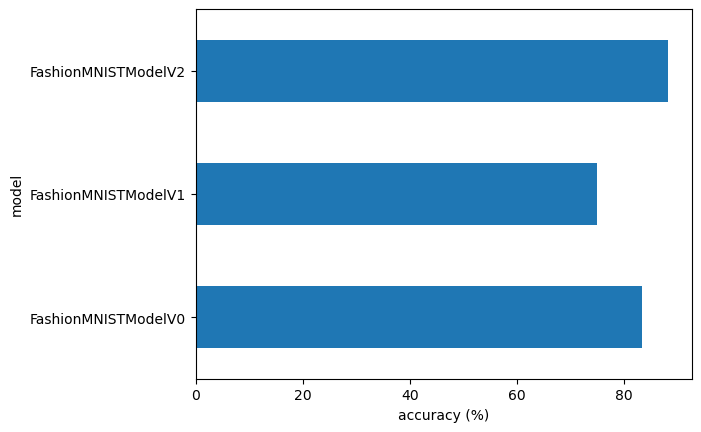

In [6]:
results_df.set_index("model_name")["accuracy"].plot(kind="barh")
plt.xlabel("accuracy (%)")
plt.ylabel("model")

# Realizamos predicciones con el mejor modelo (el CNN)

In [7]:
def make_predictions(model, data):
    pred_probs = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0)   #agregamos una dimensión como si formara parte de un paquete
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0)
            pred_probs.append(pred_prob)

    return torch.stack(pred_probs)

In [8]:
import random
#random.seed(42)
test_samples = []
test_labels = []

for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [9]:
pred_probs = make_predictions(model=loaded_model_2, data=test_samples)

# Convert prediction probabilities to labels
pred_classes = pred_probs.argmax(dim = 1)

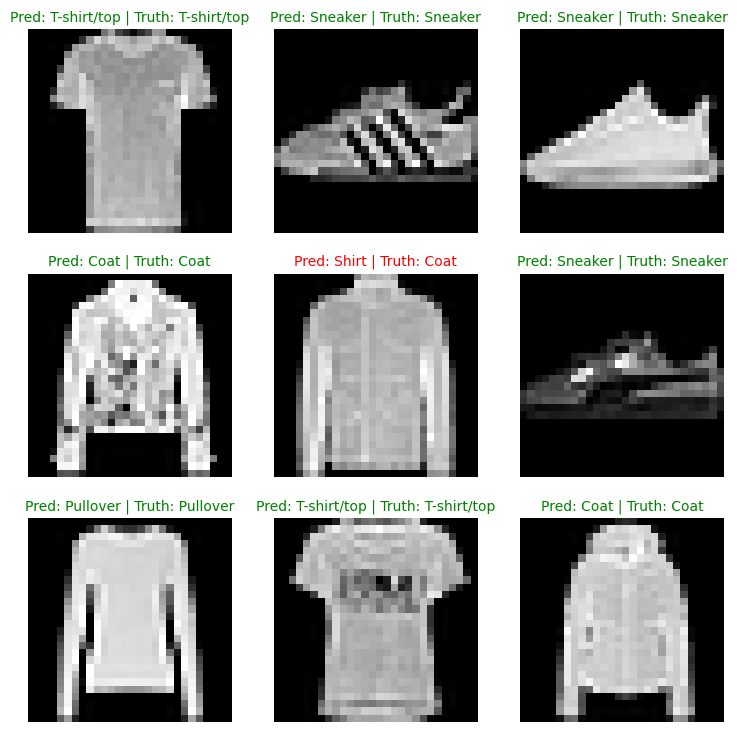

In [10]:
#plot predictions

plt.figure(figsize=(9, 9))
nrows = 3
ncols = 3

for i, sample in enumerate(test_samples):  
    plt.subplot(nrows, ncols, i+1)
    plt.imshow(sample.squeeze(), cmap="gray")
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    plt.axis(False)

    if pred_label == truth_label:
        plt.title(title_text, fontsize=10, c="g")
    else:
        plt.title(title_text, fontsize=10, c="r")
        

# Matriz de confusión para evaluación de futuras predicciones

Una matriz de confusión es un buen método para evaluar tus modelos de clasificación visualmente

1) Hacemos predicciones con el modelo entrenado sobre el dataset de testeto

2) Hacemos la matriz de confusión con torchmetrics.ConfusionMatrix

3) Ploteamos la matriz de confusión con mlxtend.plotting.plot_confussion_matrix()

In [13]:
y_preds = []
loaded_model_2.eval()

with torch.inference_mode():
    for X, y in test_dataloader:
        y_logits = loaded_model_2(X)
        y_pred = torch.softmax(y_logits.squeeze(), dim=0).argmax(dim=1)
        y_preds.append(y_pred)

y_preds_tensor = torch.cat(y_preds)
y_preds_tensor

tensor([9, 2, 1,  ..., 8, 1, 8])

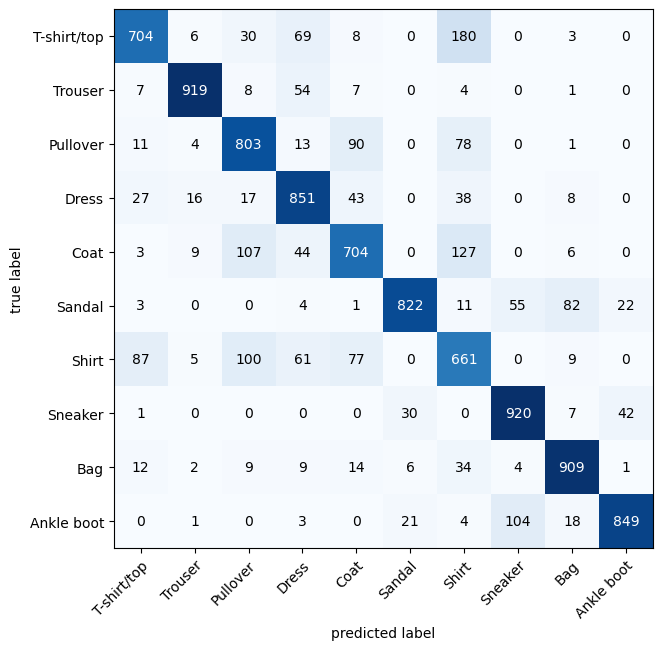

In [18]:
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

confmat = ConfusionMatrix(num_classes = len(class_names), task='multiclass')
confmat_tensor = confmat(preds = y_preds_tensor, target=test_data.targets)

fig, ax = plot_confusion_matrix(conf_mat=confmat_tensor.numpy(), class_names=class_names, figsize=(10, 7))

Una matriz de confusión ideal tiene la traza oscura y sin valores en los otros puntos ya que los valores predichos se condicen con los valores verdaderos. Esta métrica es util para estudiar los datos de entrenamiento y evaluar si los errores del modelo tienen sentido